In [ ]:
pip install PyPDF2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 2.5 MB/s eta 0:00:00


In [ ]:
import PyPDF2

In [ ]:
from PyPDF2 import PdfReader
reader = PdfReader("lyft_2021.pdf")
text=''
for i in range(len(reader.pages)):
        page=reader.pages[i]
        content=page.extract_text()
        text+=content

In [ ]:
import re

# Splitting the essay on '.', '?', and '!'
single_sentences_list = re.split(r'(?<=[.?!])\s+', text)
print (f"{len(single_sentences_list)} senteneces were found")

3445 senteneces were found


In [ ]:
sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(single_sentences_list)]
sentences[:3]

[{'sentence': 'UNITED STATESSECURITIES AND EXCHANGE COMMISSION\nWashington, D.C.',
  'index': 0},
 {'sentence': '20549\nFORM 10-K\n \n(Mark One)\n☒\nANNUAL REPORT PURS UANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934For the fiscal year ended December 31, 2021\nOR\n☐\nTRANSITION REPORT PURS UANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934 FOR THE TRANSITION PERIODFROM                      TO\nCommission File Number 001-38846\nLyft, Inc.',
  'index': 1},
 {'sentence': '(Exact name of Registrant as specified in i\nts Charter)Delaware\n20-8809830 (State or other jurisdiction of\nincorporation or organization)\n(I.R.S.',
  'index': 2}]

In [ ]:
def combine_sentences(sentences, buffer_size=1):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']

        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences

sentences = combine_sentences(sentences)

In [ ]:
pip  install  sentence_transformers

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('BAAI/bge-base-en')
embeddings_1 = model.encode([x['combined_sentence'] for x in sentences], normalize_embeddings=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/90.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/719 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = embeddings_1[i]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']

        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]

        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]['distance_to_next'] = distance

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return distances, sentences

In [ ]:
distances, sentences = calculate_cosine_distances(sentences)

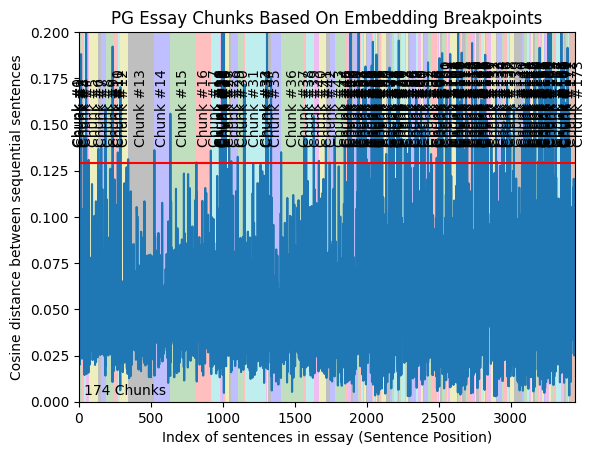

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(distances);

y_upper_bound = .2
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

# We need to get the distance threshold that we'll consider an outlier
# We'll use numpy .percentile() for this
breakpoint_percentile_threshold = 95
breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # If you want more chunks, lower the percentile cutoff
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-');

# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks");

# Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

# Start of the shading and text
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, breakpoint_index in enumerate(indices_above_thresh):
    start_index = 0 if i == 0 else indices_above_thresh[i - 1]
    end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]),
             y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
             s=f"Chunk #{i}", horizontalalignment='center',
             rotation='vertical')

# # Additional step to shade from the last breakpoint to the end of the dataset
if indices_above_thresh:
    last_breakpoint = indices_above_thresh[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]),
                 y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                 s=f"Chunk #{i+1}",
                 rotation='vertical')

plt.title("PG Essay Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in essay (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()

In [ ]:
# Initialize the start index
start_index = 0

# Create a list to hold the grouped sentences
chunks = []

# Iterate through the breakpoints to slice the sentences
for index in indices_above_thresh:
    # The end index is the current breakpoint
    end_index = index

    # Slice the sentence_dicts from the current start index to the end index
    group = sentences[start_index:end_index + 1]
    combined_text = ' '.join([d['sentence'] for d in group])
    chunks.append(combined_text)

    # Update the start index for the next group
    start_index = index + 1

# The last group, if any sentences remain
if start_index < len(sentences):
    combined_text = ' '.join([d['sentence'] for d in sentences[start_index:]])
    chunks.append(combined_text)

# grouped_sentences now contains the chunked sentences

In [ ]:
for i, chunk in enumerate(chunks[:2]):
    buffer = 200

    print (f"Chunk #{i}")
    print (chunk[:buffer].strip())
    print ("...")
    print (chunk[-buffer:].strip())
    print ("\n")

Chunk #0
UNITED STATESSECURITIES AND EXCHANGE COMMISSION
Washington, D.C. 20549
FORM 10-K
 
(Mark One)
☒
ANNUAL REPORT PURS UANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934For the fiscal year
...
ll-known seasoned issuer, as defined in Rule 405 of the Securities Act. Yes 
☒  No ☐Indicate by check mark if the Registrant is not required to file reports pursuant to Section 13 or 15(d) of the Act.


Chunk #1
Yes 
☐  No ☒Indicate by check mark whether the Registrant: (1) has filed all reports required to be filed by Section 13 or 15(d) of the Securities Exchange Act of 1934 during the preceding 12 months (
...
ed herein. Such proxy statement will be filed with the Securities and Exchange Com
mission within 120 days of the registrant’s fiscal year ended December 31, 2021. Table of ContentsPage
PART I
Item 1.




In [ ]:
pip install chromadb

In [ ]:
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
type(chunks)

list

In [ ]:
chroma_client = chromadb.Client()
chroma_collection = chroma_client.create_collection("lyft_2021", embedding_function=embedding_function)

ids = [str(i) for i in range(len(chunks))]

chroma_collection.add(ids=ids, documents=chunks)
chroma_collection.count()

174

In [ ]:
query = "What is Lyft's response to COVID-19?"
results = chroma_collection.query(query_texts=[query], n_results=10)
retrieved_documents = results['documents'][0]

for document in retrieved_documents:
    print(document)
    print('\n')

The pandemic and these related responses continue to evolve and have caused, and are expected to continue tocause,
 decreased  demand  for  our  platform  relative  to pre-COVID-19  demand,  disruptions  in  global  supply chains,  and  significant  volatility  and disruption  of  financialmarkets. The
 COVID-19 pandemic has subjected our operations, financial performance and financial condition to a number of risks, including, but not limited to, thosediscussed below:
•
Declines in travel as a result of COVID-19, including commuting, local travel, and business and leisure travel, have resulted in decreased demand for our platformwhich
 has decreased our revenues. These factors have in the past and may continue to lead to a decrease in earning opportunities for drivers on our platform. Wepaused our
 shared rides offerings as a result of COVID-19, but relaunched our shared rides offerings in select markets beginning in July 2021. While certain typesof
 travel  have  begun  to  increase 

In [ ]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
pairs = [[query, doc] for doc in retrieved_documents]
scores = cross_encoder.predict(pairs)
print("Scores:")
for score in scores:
    print(score)

Scores:
3.31949
-5.141107
3.1272767
-0.050262824
-4.0292406
-4.897515
-2.7519646
-2.1814663
-6.9932246
-3.799935


In [ ]:
print("New Ordering:")
for o in np.argsort(scores)[::-1]:
    print(o+1)

New Ordering:
1
3
4
8
7
10
5
6
2
9


In [ ]:
type(retrieved_documents)

list

In [ ]:
rank=np.argsort(scores)[::-1]
rank=list(rank+1)

In [ ]:
data = list(zip(retrieved_documents, rank))
sorted_data = sorted(data, key=lambda x: x[1])
top_5_texts = sorted_data[:5]

In [ ]:
for text, rank in top_5_texts:
    print(f"Rank: {rank}, Text: {text}")

Rank: 1, Text: The pandemic and these related responses continue to evolve and have caused, and are expected to continue tocause,
 decreased  demand  for  our  platform  relative  to pre-COVID-19  demand,  disruptions  in  global  supply chains,  and  significant  volatility  and disruption  of  financialmarkets. The
 COVID-19 pandemic has subjected our operations, financial performance and financial condition to a number of risks, including, but not limited to, thosediscussed below:
•
Declines in travel as a result of COVID-19, including commuting, local travel, and business and leisure travel, have resulted in decreased demand for our platformwhich
 has decreased our revenues. These factors have in the past and may continue to lead to a decrease in earning opportunities for drivers on our platform. Wepaused our
 shared rides offerings as a result of COVID-19, but relaunched our shared rides offerings in select markets beginning in July 2021. While certain typesof
 travel  have  begun